In [8]:
library(NormqPCR)
library(pheatmap)
library(readxl)
library(plotrix)

In [2]:
library(EnhancedVolcano)
library('tidyr')

Loading required package: ggplot2

Loading required package: ggrepel


Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




In [3]:
######################################## 
### FUNCTION FOR RLE-PLOT AND RUV_total
########################################

RLEplot_mod <- function(data,pdata_group){
  
Color_Batches <- c('purple','orange','brown','blue','darkgreen','pink','gray','red','black','green','navy','Violet')
par(mar = c(6.5,6.5,2.3,0))
boxplot(data - rowMedians(data), main = '', xlab ='', ylab = '', xaxt = 'n', yaxt = 'n', ylim = c(-4.1,4.1),xlim=c(0,50),
        outline = FALSE, names = FALSE, frame = FALSE, whisklty = 3, whisklwd = 1.5, staplelty = 1, notch = TRUE, boxlwd = 2,
        staplelwd = 0 , boxcol = Color_Batches[factor(pdata_group)],
        border = Color_Batches[factor(pdata_group)], col = 'gray87')
box(lwd = 7, bty = 'l')
title('RLE plot', line = -2, cex.main = 3.5)
Median_Nano <- apply(data - rowMedians(data), 2, median)
points(c(1:ncol(data)), Median_Nano, col = Color_Batches[factor(pdata_group)], pch = 19, cex = 1.2)
axis(2, mgp = c(3.5, .9 ,0), lwd.ticks=6, las=1, cex.axis=3)
mtext('RLE', 2, line = 3.5, cex = 3.5)
abline(h = 0, col = 'black', lwd = 5, lty = 2)
par(lwd = 3)
axis.break(2, -4.2, style = 'zigzag', brw = .02)
x_labs <- levels(factor(colnames(data)))

text(x = seq_along(x_labs), y = -4.5, labels = x_labs, 
     srt = 90,    # rotate
     adj = 1,    # justify
     xpd = TRUE)    # plot in margin

legend(36, 4.1, legend = unique(factor(pdata_group)),
       col = unique(Color_Batches[factor(pdata_group)]),
       pch = 15, bty = 'n', cex = 1)
text(x = 40, y = 4.2 ,labels  = 'Run', cex = 1.5)

}

In [4]:
##### FUNCTION FOR RUVg  ### Bhattacharia et. al. 

RUV_total <- function(raw,pData,fData,k,hkgenes = NULL,exclude = NULL){
  
  library(RUVSeq)
  library(DESeq2)
  library(limma)
  library(matrixStats)
  
  if (!is.null(hkgenes)){
    
    fData(set)$CodeClass[rownames(set) %in% hkgenes] = 'Housekeeping'
    
  }
  
  
  fData = fData[rownames(raw),]
  int = intersect(rownames(raw),rownames(fData))
  fData = fData[int,]
  raw = raw[int,]
  
  set <- newSeqExpressionSet(as.matrix(round(raw)),
                             phenoData=pData,
                             featureData=fData)
  
  cIdx <- rownames(set)[fData(set)$`Class Name` == "Housekeeping"]
  cIdx = cIdx[!(cIdx %in% exclude)]
  x <- as.factor(pData$Group)
  set <- betweenLaneNormalization(set, which="upper")
  set <- RUVg(set, cIdx, k=k)
  dds <- DESeqDataSetFromMatrix(counts(set),colData=pData(set),design=~1)
  rowData(dds) <- fData
  dds <- estimateSizeFactors(dds)
  dds <- estimateDispersionsGeneEst(dds)
  cts <- counts(dds, normalized=TRUE)
  disp <- pmax((rowVars(cts) - rowMeans(cts)),0)/rowMeans(cts)^2
  mcols(dds)$dispGeneEst <- disp
  dds <- estimateDispersionsFit(dds, fitType="mean")
  vsd <- varianceStabilizingTransformation(dds, blind=FALSE)
  mat <- assay(vsd)
  covars <- as.matrix(colData(dds)[,grep("W",colnames(colData(dds))),drop=FALSE])
#   mat_has_na = count(is.na(mat))
#   covar_has_na = count(is.na(covars))
#   if (mat_has_na > 0) {
#       print('mat has na values')
#   }
#   if (covar_has_na > 0) {
#       print('covar has na values')
#       print(covars)
#   }
  
  mat <- removeBatchEffect(mat, covariates=covars)
  assay(vsd) <- mat
  return(list(set = set,vsd = vsd))
  
}

In [5]:
RLEplot_mod <- function(data, pdata_group) {
  
  Color_Batches <- c('purple', 'orange', 'brown', 'blue', 'darkgreen', 'pink', 'gray', 'red', 'black', 'green', 'navy', 'Violet')
  
  par(mar = c(6.5, 6.5, 2.3, 2.3))  # Adjust the margin parameters
  par(plt = c(0.1, 0.9, 0.1, 0.9))  # Adjust the plot area parameters
  boxplot(data - rowMedians(data), main = '', xlab = '', ylab = '', xaxt = 'n', yaxt = 'n', ylim = c(-4.1, 4.1), xlim = c(0, 50),
          outline = FALSE, names = FALSE, frame = FALSE, whisklty = 3, whisklwd = 1.5, staplelty = 1, notch = TRUE, boxlwd = 2,
          staplelwd = 0, boxcol = Color_Batches[factor(pdata_group)],
          border = Color_Batches[factor(pdata_group)], col = 'gray87')
  box(lwd = 7, bty = 'l')
  title('RLE plot', line = -2, cex.main = 3.5)
  Median_Nano <- apply(data - rowMedians(data), 2, median)
  points(c(1:ncol(data)), Median_Nano, col = Color_Batches[factor(pdata_group)], pch = 19, cex = 1.2)
  axis(2, mgp = c(3.5, .9, 0), lwd.ticks = 6, las = 1, cex.axis = 3)
  mtext('RLE', 2, line = 3.5, cex = 3.5)
  abline(h = 0, col = 'black', lwd = 5, lty = 2)
  par(lwd = 3)
  axis.break(2, -4.2, style = 'zigzag', brw = .02)
  x_labs <- levels(factor(colnames(data)))
  text(x = seq_along(x_labs), y = -4.5, labels = x_labs,
       srt = 90,    # rotate
       adj = 1,    # justify
       xpd = TRUE)    # plot in margin
  
  legend(36, 4.1, legend = unique(factor(pdata_group)),
         col = unique(Color_Batches[factor(pdata_group)]),
         pch = 15, bty = 'n', cex = 1)
  text(x = 40, y = 4.2, labels = 'Run', cex = 1.5)
  
}

In [6]:
RLEplot_mod <- function(data, pdata_group) {
  
  Color_Batches <- c('purple', 'orange', 'brown', 'blue', 'darkgreen', 'pink', 'gray', 'red', 'black', 'green', 'navy', 'Violet')
  
  par(mar = c(6.5, 6.5, 2.3, 2.3))  # Adjust the margin parameters
  par(plt = c(0.1, 0.9, 0.1, 0.9))  # Adjust the plot area parameters
  boxplot(data - rowMedians(data), main = '', xlab = '', ylab = '', xaxt = 'n', yaxt = 'n', ylim = c(-4.1, 4.1), xlim = c(0, 50),
          outline = FALSE, names = FALSE, frame = FALSE, whisklty = 3, whisklwd = 1.5, staplelty = 1, notch = TRUE, boxlwd = 2,
          staplelwd = 0, boxcol = Color_Batches[factor(pdata_group)],
          border = Color_Batches[factor(pdata_group)], col = 'gray87')
  box(lwd = 7, bty = 'l')
  title('RLE plot', line = -2, cex.main = 3.5)
  Median_Nano <- apply(data - rowMedians(data), 2, median)
  points(c(1:ncol(data)), Median_Nano, col = Color_Batches[factor(pdata_group)], pch = 19, cex = 1.2)
  axis(2, mgp = c(3.5, .9, 0), lwd.ticks = 6, las = 1, cex.axis = 3)
  mtext('RLE', 2, line = 3.5, cex = 3.5)
  abline(h = 0, col = 'black', lwd = 5, lty = 2)
  par(lwd = 3)
  axis.break(2, -4.2, style = 'zigzag', brw = .02)
  x_labs <- levels(factor(colnames(data)))
  text(x = seq_along(x_labs), y = -4.5, labels = x_labs,
       srt = 90,    # rotate
       adj = 1,    # justify
       xpd = TRUE)    # plot in margin
  
  legend(36, 4.1, legend = unique(factor(pdata_group)),
         col = unique(Color_Batches[factor(pdata_group)]),
         pch = 15, bty = 'n', cex = 1)
  text(x = 40, y = 4.2, labels = 'Run', cex = 1.5)
  
}

In [13]:
raw = read.csv('Data/raw_count_transponsed_raw.csv', row.names = 1, check.names = F )
norm_count = read.csv('Data/raw_count.csv', row.names = 1, check.names = F)
# sample annotations:
# annot = read.csv('Data/annot_3.csv', row.names = 1, check.names = F )
annot = read.csv('Data/annot_clinical.csv', row.names = 1, check.names = F )
# annot = read.csv('Data/annot_clinical_2.csv', row.names = 1, check.names = F )

# gene annotations:
gannot = read.csv('Data/gannot_raw.csv', row.names = 1, check.names = F )
old_gannot=read.csv('Data/gannot.csv', row.names = 1, check.names = F)
clin = read.csv('Data/annot.csv', row.names = 1, check.names = F )

In [14]:
raw_expression <- raw
dim(raw_expression)

[1] 784  48

In [15]:
fData=gannot
head(fData)

,Class Name,% Samples above Threshold,Immune Response Category,Accession,Common Name,Gene_Class
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
A2M,Endogenous,100,Chemokines,NM_000014.4,A2M,Immune Response
ABCB1,Endogenous,100,,NM_000927.3,ABCB1,Immune Response
ABCF1,Housekeeping,100,,NM_001090.2,ABCF1,HK
ABL1,Endogenous,100,"Cell Cycle, Regulation, Senescence",NM_005157.3,ABL,Immune Response
ADA,Endogenous,100,"B-Cell Functions, T-Cell Functions",NM_000022.2,ADA,Immune Response
ADORA2A,Endogenous,100,Cell Functions,NM_000675.3,ADORA2A,Immune Response - Checkpoint


In [16]:
fData$IsControl = fData$`Class Name`!='Endogenous'

In [17]:
raw_expression_ex = raw_expression

In [18]:
pData <- annot[colnames(raw_expression),]
pData

,Conditions,Diagnosis,pid,Is_matched,Subject_ID,RECIST_response,TTP2n,group
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
20230616_210462891024_K1241-B_02.RCC,Soft Tissue Sarcoma,Baseline,K1241,True,TI0045,SD,PFS3.Y,OTHER ADVANCED SARCOMAS
20230616_210462891024_K1628-B_03.RCC,Soft Tissue Sarcoma,Baseline,K1628,True,TI0036,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K1865-B_04.RCC,Osteosarcoma,Baseline,K1865,False,TI0004,PD,PFS3.N,ADVANCED OSTEOSARCOMA
20230616_210462891024_K2032-B_05.RCC,Soft Tissue Sarcoma,Baseline,K2032,True,TI0047,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2068-B_06.RCC,Soft Tissue Sarcoma,Baseline,K2068,False,TI0035,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2323-B_07.RCC,Soft Tissue Sarcoma,Baseline,K2323,False,TI0033,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2360-B_08.RCC,Soft Tissue Sarcoma,Baseline,K2360,True,TI0030,SD,PFS3.Y,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2520-B_09.RCC,Soft Tissue Sarcoma,Baseline,K2520,False,TI0012,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2669-B_10.RCC,Soft Tissue Sarcoma,Baseline,K2669,False,TI0059,SD,PFS3.Y,OTHER ADVANCED SARCOMAS


In [19]:
fData_ex = fData

In [20]:
k = 3  
vsd = RUV_total(raw_expression_ex,pData,
                fData_ex,k = k)$vsd ## put exclude if there any hk associated with biology of interest 
set = RUV_total(raw_expression_ex,pData,
                fData_ex,k = k)$set # ,exclude = exc

Loading required package: EDASeq

Loading required package: ShortRead

Loading required package: BiocParallel

Loading required package: Biostrings

Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:tidyr’:

    expand


The following objects are masked from ‘package:Matrix’:

    expand, unname


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: XVector

Loading required package: GenomeInfoDb


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit


Loading required package: Rsamtools

Loading required package: GenomicRanges

Loading required package: GenomicAlignments

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required pa

In [21]:
normalizedcount <- set@assayData[["normalizedCounts"]]

In [22]:
col_data = pData(set)

In [23]:
count_data = counts(set)

In [24]:
dds_w1_2 <- DESeqDataSetFromMatrix(countData = count_data,
                              colData = col_data,
                                   design= ~ W_1 +  Conditions ) #counts(set)[1:652,], ##use design with W_1 or W_2 based on k value
dds_w1_2 <- DESeq(dds_w1_2)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, an

In [25]:
resultsNames(dds_w1_2)

[1] "Intercept"                                       
[2] "W_1"                                             
[3] "Conditions_Soft.Tissue.Sarcoma._vs_Osteosarcoma."

In [26]:
res_valcanoplot2 <- results(dds_w1_2)

In [27]:
firstC <- 'Soft Tissue Sarcoma'
SecondC <- 'Osteosarcoma'
contrast<- c("Conditions",firstC,SecondC)

In [28]:
res1_2 <- results(dds_w1_2, name="Conditions_Soft.Tissue.Sarcoma._vs_Osteosarcoma.")
res_deseq2_2 <- as.data.frame(results(dds_w1_2))
nam <- paste('up_in',firstC, sep = '_')
res_deseq2_2[, nam] <- as.logical(res_deseq2_2$log2FoldChange > 0)

res_deseq2_2$threshold <- as.logical(res_deseq2_2$padj < 0.05)  #Threshold defined earlier
row.names(res_deseq2_2)[which(res_deseq2_2$threshold)]

[1] "A2M"     "AMBP"    "BCL2"    "CD24"    "CD34"    "CD97"    "CDH1"   
 [8] "CDH5"    "CFD"     "CTLA4"   "CX3CL1"  "CXCL14"  "CXCL2"   "CXCL5"  
[15] "CYFIP2"  "DUSP4"   "FN1"     "ICAM3"   "IL17B"   "IL24"    "IL7R"   
[22] "INPP5D"  "IRAK1"   "IRF4"    "ITGA4"   "ITK"     "KIT"     "LAG3"   
[29] "LGALS3"  "MCAM"    "NCAM1"   "RORC"    "SMPD3"   "SSX1"    "TAL1"   
[36] "TCF7"    "TICAM2"  "TLR3"    "TNFRSF4" "TNFSF14"

In [29]:
norm_mean_w1_2 <- sapply( levels(dds_w1_2$Conditions), function(lvl) rowMeans( counts(dds_w1_2,normalized=TRUE)[,dds_w1_2$Conditions == lvl, drop=F] ) )
colnames(norm_mean_w1_2) <- paste('Rowmean_exp_',levels(dds_w1_2$Conditions),sep='')
res3_2 <- cbind(norm_mean_w1_2,res_deseq2_2)
top_de_genes_2 = na.omit(res3_2[res3_2$threshold==TRUE,])
top_de_genes_2   

,Rowmean_exp_Osteosarcoma,Rowmean_exp_Soft Tissue Sarcoma,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,up_in_Soft Tissue Sarcoma,threshold
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
A2M,2790.639315,6800.11593,4795.37762,1.7076245,0.4325662,3.947661,7.891852e-05,3.952502e-03,TRUE,TRUE
AMBP,391.822180,128.06932,259.94575,-3.4452199,0.9651277,-3.569704,3.573855e-04,1.022803e-02,FALSE,TRUE
BCL2,147.086532,347.43228,247.25941,0.9176894,0.2934350,3.127402,1.763585e-03,3.254600e-02,TRUE,TRUE
CD24,2100.981311,847.36979,1474.17555,-2.0694606,0.6208080,-3.333495,8.576218e-04,2.061723e-02,FALSE,TRUE
CD34,77.769361,204.41857,141.09397,1.4948209,0.3874063,3.858535,1.140686e-04,5.011474e-03,TRUE,TRUE
CD97,296.721658,600.00229,448.36197,1.1808538,0.2956400,3.994228,6.490536e-05,3.900812e-03,TRUE,TRUE
CDH1,59.257298,308.57583,183.91656,2.9107859,0.6404052,4.545225,5.487649e-06,4.930442e-04,TRUE,TRUE
CDH5,90.846947,189.86946,140.35820,1.2830380,0.4096784,3.131818,1.737276e-03,3.254600e-02,TRUE,TRUE
CFD,266.638138,990.79539,628.71676,1.6970488,0.5686330,2.984436,2.841014e-03,4.493288e-02,TRUE,TRUE


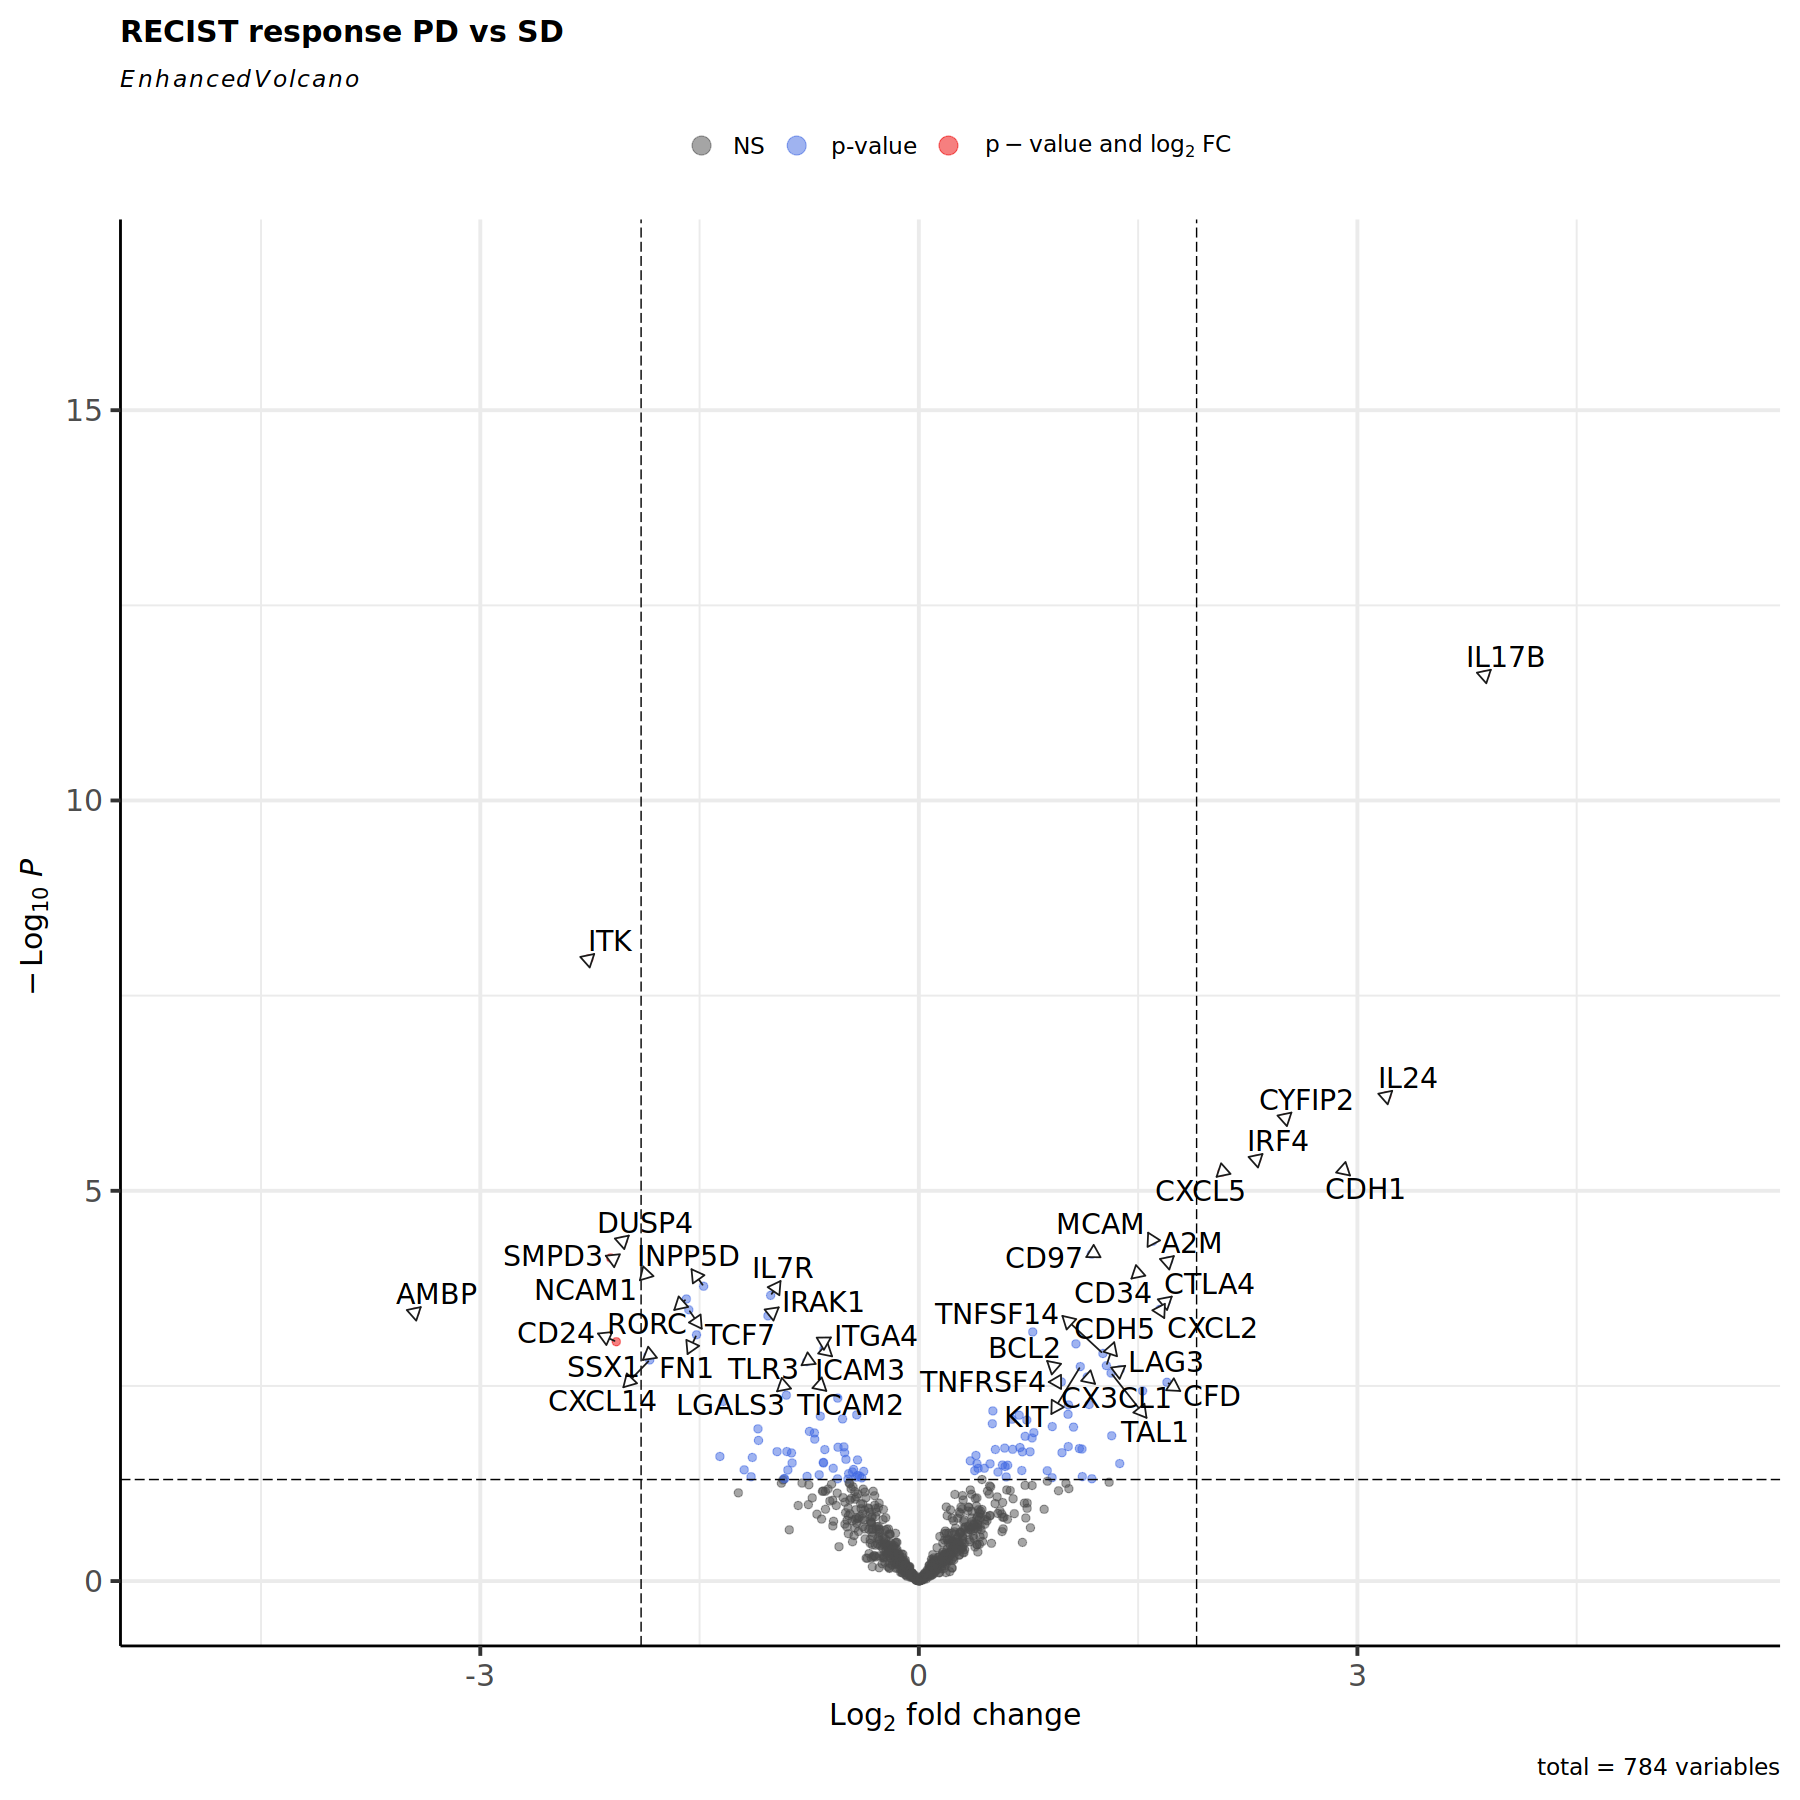

In [35]:
# options(repr.plot.width=15, repr.plot.height=15)
# EnhancedVolcano(res_valcanoplot2,
#                 lab = rownames(res_valcanoplot2),
#                 selectLab = row.names(top_de_genes_2),
#                 x = 'log2FoldChange',
#                 y = 'pvalue',
#                 title = 'RECIST response PD vs SD',drawConnectors = TRUE, max.overlaps = 35,
#                 pCutoff = 0.05,
#                 FCcutoff = 1.9,
#                 pointSize = 2.0,
#                 labSize = 6.0)

In [31]:
options(repr.plot.width=17, repr.plot.height=17)
# pdf("01_SD_vs_PD_volcano_plot.pdf")
# jpeg('01_SD_vs_PD_volcano_plot.jpg')

# dev.off()
# sdvspd_volplot
pdf("05_Osteosarcoma_vs_Soft_Tissue_Sarcoma_volcano_plot.pdf", width=15, height=15)
print(EnhancedVolcano(res_valcanoplot2,
                lab = rownames(res_valcanoplot2),
                selectLab = row.names(top_de_genes_2),
                x = 'log2FoldChange',
                y = 'pvalue',
                title = 'Osteosarcoma vs Soft Tissue Sarcoma',drawConnectors = TRUE,max.overlaps = 35,
                pCutoff = 0.05,
                FCcutoff = 1.9,
                pointSize = 2.0,
                labSize = 6.0))
graphics.off()

In [29]:
goi = c('IL17B', 'IL24', 'ITK', 'DUSP4')

In [30]:
colData(dds_w1_2)
tcounts <- t(log2((counts(dds_w1_2[goi, ], normalized=TRUE, replaced=FALSE)+.5))) %>%
  merge(colData(dds_w1_2), ., by="row.names") %>%
  gather(gene, expression, (ncol(.)-length(goi)+1):ncol(.))

DataFrame with 48 rows and 12 columns
                                                Conditions   Diagnosis
                                                  <factor> <character>
20230616_210462891024_K1241-B_02.RCC  Soft Tissue Sarcoma     Baseline
20230616_210462891024_K1628-B_03.RCC  Soft Tissue Sarcoma     Baseline
20230616_210462891024_K1865-B_04.RCC  Osteosarcoma            Baseline
20230616_210462891024_K2032-B_05.RCC  Soft Tissue Sarcoma     Baseline
20230616_210462891024_K2068-B_06.RCC  Soft Tissue Sarcoma     Baseline
...                                                    ...         ...
20230707_210462901024_K3975-Tx_08.RCC Osteosarcoma           Treatment
20230707_210462901024_K4106-Tx_09.RCC Osteosarcoma           Treatment
20230707_210462901024_K4258-Tx_10.RCC Osteosarcoma           Treatment
20230707_210462901024_K4360-Tx_11.RCC Osteosarcoma           Treatment
20230707_210462901024_K4368-Tx_12.RCC Soft Tissue Sarcoma    Treatment
                                       

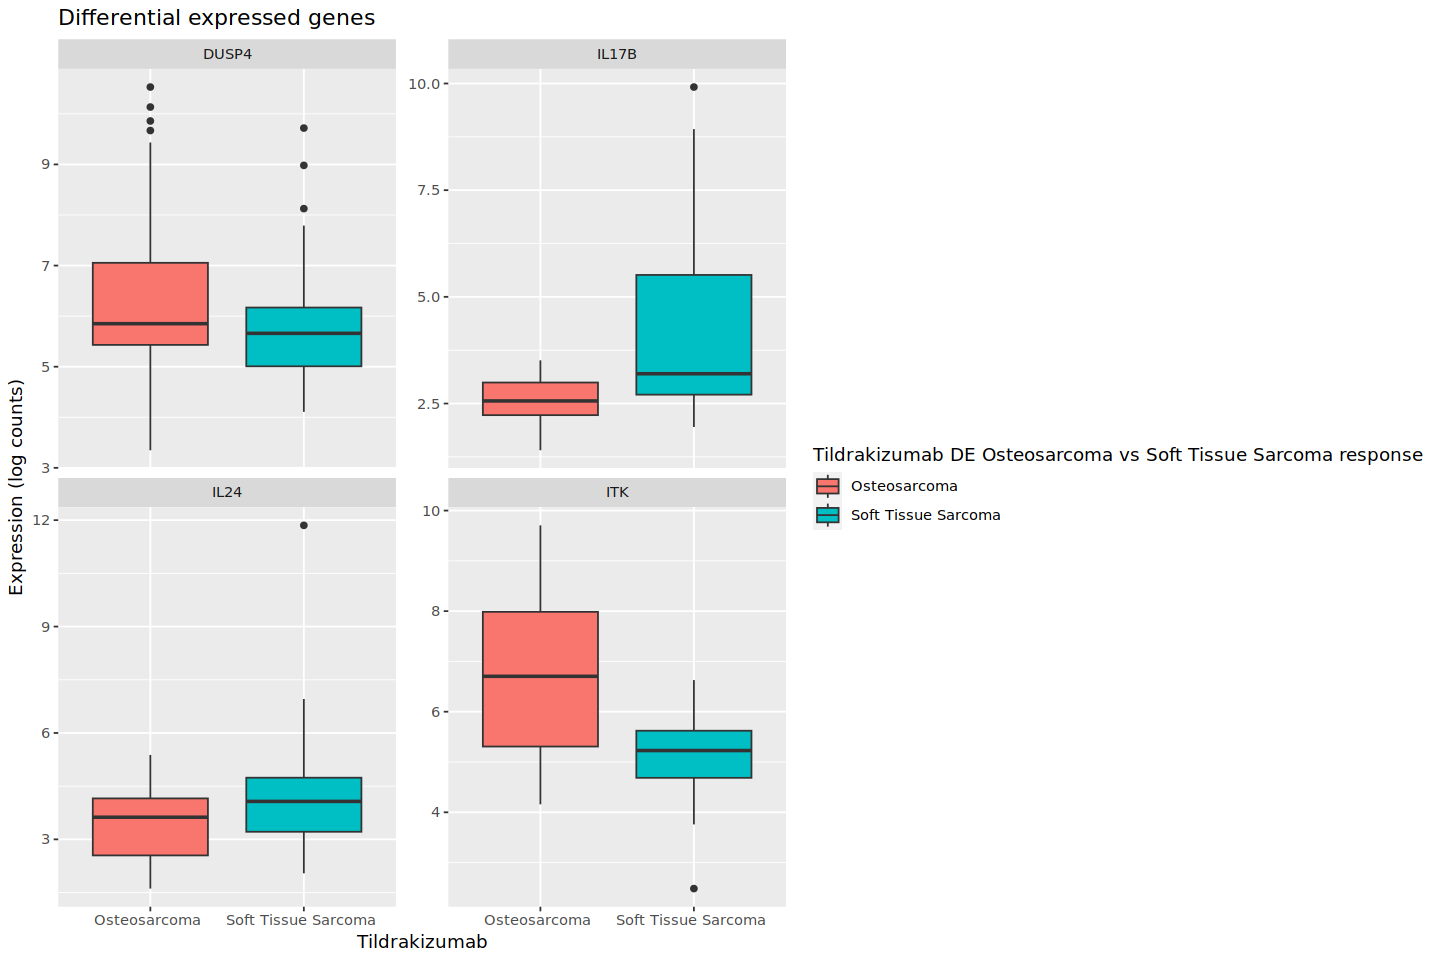

In [33]:
options(repr.plot.width=12, repr.plot.height=8)
sd_boxplot = ggplot(tcounts, aes(Conditions, expression, fill=Conditions)) + 
  geom_boxplot() + 
  facet_wrap(~gene, scales="free_y") + 
  labs(x="Tildrakizumab", 
       y="Expression (log counts)", 
       fill="Tildrakizumab DE Osteosarcoma vs Soft Tissue Sarcoma response", 
       title="Differential expressed genes")
sd_boxplot

In [35]:
pdf("05_Osteosarcoma_vs_Soft_Tissue_Sarcoma_box_plot_top_DE_genes.pdf", width=12, height=8)
print(sd_boxplot)
graphics.off()

In [33]:
top_de_genes_2

,Rowmean_exp_Osteosarcoma,Rowmean_exp_Soft Tissue Sarcoma,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,up_in_Soft Tissue Sarcoma,threshold
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
A2M,2790.639315,6800.11593,4795.37762,1.7076245,0.4325662,3.947661,7.891852e-05,3.952502e-03,TRUE,TRUE
AMBP,391.822180,128.06932,259.94575,-3.4452199,0.9651277,-3.569704,3.573855e-04,1.022803e-02,FALSE,TRUE
BCL2,147.086532,347.43228,247.25941,0.9176894,0.2934350,3.127402,1.763585e-03,3.254600e-02,TRUE,TRUE
CD24,2100.981311,847.36979,1474.17555,-2.0694606,0.6208080,-3.333495,8.576218e-04,2.061723e-02,FALSE,TRUE
CD34,77.769361,204.41857,141.09397,1.4948209,0.3874063,3.858535,1.140686e-04,5.011474e-03,TRUE,TRUE
CD97,296.721658,600.00229,448.36197,1.1808538,0.2956400,3.994228,6.490536e-05,3.900812e-03,TRUE,TRUE
CDH1,59.257298,308.57583,183.91656,2.9107859,0.6404052,4.545225,5.487649e-06,4.930442e-04,TRUE,TRUE
CDH5,90.846947,189.86946,140.35820,1.2830380,0.4096784,3.131818,1.737276e-03,3.254600e-02,TRUE,TRUE
CFD,266.638138,990.79539,628.71676,1.6970488,0.5686330,2.984436,2.841014e-03,4.493288e-02,TRUE,TRUE


In [34]:
write.csv(top_de_genes_2, file = 'DEseq2_DGE_Ostereo_vs_Non_ostereo.csv')

In [36]:
library("pheatmap")

In [37]:
ntd <- normTransform(dds_w1_2)

In [42]:
select <- order(rowMeans(counts(dds_w1_2,normalized=TRUE)),
                decreasing=TRUE)[1:20]
df <- as.data.frame(colData(dds_w1_2)[,c("Conditions")])
# df

In [45]:
dds_w1_2 <- estimateSizeFactors(dds_w1_2)
# badgenes<-names(which(apply(counts(dds_w1_2), 1, function(x){sum(x < 5)}) > 0.9 * ncol(dds_w1_2)))
# ddsFiltered <- dds[which(!rownames(dds_w1_2) %in% badgenes), ]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



In [43]:
rld <- vst(dds_w1_2, blind=FALSE)
de<- rownames(top_de_genes_2[top_de_genes_2$padj<0.05, ])
de_mat <- assay(rld)[de,]

ERROR: Error in vst(dds_w1_2, blind = FALSE): less than 'nsub' rows,
  it is recommended to use varianceStabilizingTransformation directly


In [41]:
pheatmap(assay(ntd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

ERROR: Error in check.length("fill"): 'gpar' element 'fill' must not be length 0
